# Header

In [1]:
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
#%matplotlib notebook

import numpy as np
import scipy as s
import scipy.signal as sig

In [2]:
# Check directory
os.chdir("D:\Raphael\Dropbox\Mcgill\JupyterNotebook\PHYS512")
os.getcwd()

'D:\\Raphael\\Dropbox\\Mcgill\\JupyterNotebook\\PHYS512'

# Functions

In [324]:
# returnm some important and used much values of the histogram
def histo_imp_val(rho, edge):
    nx = len(rho[0]) # number of bins in x
    ny = len(rho[1])
    nz = len(rho[2])
    dx = edge[0][1]-edge[0][0] # size of bin in x
    dy = edge[1][1]-edge[1][0]
    dz = edge[2][1]-edge[2][0]
    minx = edge[0][0] #end of each axes
    miny = edge[1][0]
    minz = edge[2][0]
    return nx,ny,nz,dx,dy,dz,minx,miny,minz

In [325]:
# Define single ptcl softened potential (softened green's function), given a density matrix shape
def soft_pot(rho,edge,a):
    pot =rho*0 #initialise potential matrix
    nx = len(rho[0]) # number of bins in x
    ny = len(rho[1])
    nz = len(rho[2])
    dx = edge[0][1]-edge[0][0] # size of bin in x
    dy = edge[1][1]-edge[1][0]
    dz = edge[2][1]-edge[2][0]
    centerx = (edge[0][-1]-edge[0][0])/2 # center of x axis
    centery = (edge[1][-1]-edge[1][0])/2
    centerz = (edge[2][-1]-edge[2][0])/2
    for i in range(nx):
        for j in range(ny):
            for k in range(nz): # looking at some bin i,j,k
                x = (i+0.5)*dx-centerx # position of the center of the bin in x, given ptcl at x=0.5 (i.e at the center, since x=[0,1) )
                y = (j+0.5)*dy-centery
                z = (k+0.5)*dz-centerz
                r = np.sqrt(x**2+y**2+z**2) # distance btw center of bin and and particle
                if r**3<=a:
                    pot[i,j,k] = r/a # potential for bins close to ptcl
                else:
                    pot[i,j,k] = 1/r**2 # potential for bins far from ptcl
    return pot

In [326]:
# return the ijk coordinate of a (ONE) given cell position (x_n)
def x_to_ijk(x_n, rho, edge):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    x = x_n[0]
    y = x_n[1]
    z = x_n[2]
    i = int(round((x-minx)/dx - 0.5))
    j = int(round((y-miny)/dy - 0.5))
    k = int(round((z-minz)/dz - 0.5))
    #print(i,j,k) #debugging
    return i,j,k

In [327]:
# return the ijk coordinate of a set of (MANY) cell position(x_n)
def xn_to_ijk(x_n, rho, edge):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    indices = np.zeros(shape=(len(x_n),3))
    for n in range(len(x_n)):
        x = x_n[n][0]
        y = x_n[n][1]
        z = x_n[n][2]
        i = int(round((x-minx)/dx - 0.5))
        j = int(round((y-miny)/dy - 0.5))
        k = int(round((z-minz)/dz - 0.5))
        indices[n]  = (i,j,k)
    #print(i,j,k) #debugging
    return indices

In [328]:
# Order the elements in x_n in order of ascending x, then y, then z
def order_x(x,rho,edge):
    indices = xn_to_ijk(x, rho, edge)
    return x[np.lexsort((np.transpose(indices)[2],np.transpose(indices)[1],np.transpose(indices)[0]))]

In [329]:
# Allow to transform the rho nxnxn matrix to a nx3 matrix of all the points position,
# thus allowing us to plot it using plot_graph3D()
def rho_to_x(rho):
    x = np.array([[0,0,0]])
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    for i in range(nx):
        #print("i=",i) #Debugging
        for j in range(ny):
            for k in range(nz):
                if rho[i,j,k] != 0.:
                    for nb_ptcl in range(int(rho[i,j,k])):
                        position = np.array([[(i+0.5)*dx+minx,(j+0.5)*dy+miny,(k+0.5)*dz+minz]])# obtain position
                        x = np.concatenate((x,position),axis=0)# add it to the list of points x
                    
    return x[1:] #removes the first dummy point [0,0,0] and return x

In [330]:
def ijk_to_x(i,j,k,rho,edge):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    return np.array([[(i+0.5)*dx+minx,(j+0.5)*dy+miny,(k+0.5)*dz+minz]])

## Plot functions

In [353]:
# define function for easy visual check (thanks Marcus!)
def plot_2D_collapse(H,edges):
    edges_x = edges[0]
    edges_y = edges[1]
    edges_z = edges[2]
    fig,ax = plt.subplots(figsize=(5,5), dpi=100)
    im = ax.imshow(
        H.sum(axis=2),
        origin="lower",
        extent=(edges_x.min(), edges_x.max(), edges_y.min(), edges_y.max()), 
        aspect="auto")
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    minor_ticks_x = edges_x
    minor_ticks_y = edges_y
    ax.set(xlim=(minor_ticks_y[0], minor_ticks_y[-1]), ylim=(minor_ticks_x[0], minor_ticks_x[-1]))
    ax.set_xticks(minor_ticks_y, minor=True)
    ax.set_yticks(minor_ticks_x, minor=True)

    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    plt.show

In [354]:
#Return a 3D plot of the given x
def plot_graph3D(x, edge, title ="", scale_factor = 100,save=False, show = True, name = "fig",n = 0, view1=20,view2=60):
    #Create figure
    x = np.transpose(x)
    fig=plt.figure(figsize=(10,10))#Create 3D axes
    ax=Axes3D(fig) 
    ax.scatter(x[0], x[1], x[2], color="royalblue", marker=".",s=.02*scale_factor)
    ax.set_xlabel("x-coordinate",fontsize=14)
    ax.set_ylabel("y-coordinate",fontsize=14)
    ax.set_zlabel("z-coordinate",fontsize=14)
    ax.set_title(title,fontsize=20)
    #ax.legend(loc="upper left",fontsize=14)
    #ax.xaxis.set_ticklabels([])
    #ax.yaxis.set_ticklabels([])
    #ax.zaxis.set_ticklabels([])
    ax.set_xlim3d(edge[0].min(),edge[0].max())
    ax.set_ylim3d(edge[1].min(),edge[1].max())
    ax.set_zlim3d(edge[2].min(),edge[2].max())
    ax.view_init(view1,view2)
    plt.show
    if save:
        plt.savefig('Pictures_Final_Project/{}{}.png'.format(name,n), dpi=100)
    if show  == False:
        plt.close(fig)

# Code

In [369]:
def Energy(x,v,phi,rho,edge,m=1):
    i,j,k = x_to_ijk(x,rho,edge)
    K = 0.5*m*np.sum(v**2)
    P = -0.5*phi[i,j,k]
    return K+P,K,P

In [370]:
# Initialize the NxNxN matrix with the ptcl in it
# Create the density Matrix
# Order the ptcl such that they are in ascending order
# Create the Green's Function
# Compute Potential
def Initialize(x, size, a = 0.005, plot_2D = True, plot_3D = False, sc_factor = 10000):
    # Create density matrix rho
    print("Density rho :")
    rho,edge = np.histogramdd(x,bins=size,range=((-1,1),(-1,1),(-1,1)))
    if plot_2D: plot_2D_collapse(rho,edge)
    print(" -- COMPLETE --")

    print("Order x :")
    # Order the x in order of ascending x, then y, then z
    x = order_x(x,rho, edge)
    print(" -- COMPLETE --")
    
    # Create softened potential matrix s_pot
    print("Green's Func :")
    greens_f = soft_pot(rho,edge,a)
    if plot_2D: plot_2D_collapse(greens_f,edge)
    print(" -- COMPLETE --")

    # Compute total potential matrix by convolving the density matrix with the softened potential
    # NOTE : the potential phi will be compute once again in Evolve(); this is only for visual check.
    print("Potential :")
    phi = sig.fftconvolve(rho,greens_f,mode='same')
    if plot_2D: plot_2D_collapse(phi,edge)
    print(" -- COMPLETE --")
    
    plot_graph3D(x,edge,scale_factor = sc_factor,save=False,show=plot_3D)
    
    return x, rho, edge, greens_f, phi

In [371]:
# evolve the system for nb_step time
def Evolve(dt, size, nb_step, x_n, rho_n, phi_n, rho, edge, greens_f, v_n0, 
           show_freq=1,sc_factor=100,plot_3D = True, plot_E = True, save_3D=False, 
           name_file = "fig", view1=20,view2=60):
    # check for inital velocity. if no inital velocity, set v_0 to 0 for all i,j,k,d
    v_n = v_n0
    
    # create a array to store the energy values
    E_values = np.zeros(shape=(nb_step+1,3))
    
    for nb in range(nb_step):
        print("Step :",nb)#, end =" ") # print actual step
        
        # plot the ptcls in a 3D graph
        if nb%show_freq==0:# make an image if the step is a multiple of show_freq.
            plot_graph3D(x_n,edge,title = "Step {}".format(nb), 
                         scale_factor = sc_factor,save=save_3D, show = plot_3D, 
                         name = name_file,n = nb, view1=view1,view2=view2)
            
        # Compute total potential matrix by convolving the density matrix with the softened potential
        phi_n = sig.fftconvolve(rho_n,greens_f,mode='same')
            
        # Compute acceleration
        # NOTE : since I taking the transpose such that acc has dimension NxNxNx3, the indices are now (k,j,i,d).
        acc_n = np.transpose(np.gradient(phi_n))
        
        # set an empty array for v_n1
        v_n1 = v_n*0
        # set an empty array for x_n1
        x_n1 = x*0         
        
        # Set energy to 0 (will be compute in the following for loop)
        E = np.zeros(3)
        for ptcl in range(len(x_n)): #for all ptcl in x_n
            E = E + Energy(x_n[ptcl],v_n,phi_n,rho_n,edge)
            i,j,k = x_to_ijk(x_n[ptcl], rho, edge)# get the ptcl position in the matrix
            v_n1[ptcl] = v_n[ptcl] + 0.5*acc_n[k,j,i]*dt
            x_n1[ptcl] = x_n[ptcl] + v_n1[ptcl]*dt #update that said ptcl position
            #for d in range(3): x_n1[ptcl][d] = (x_n1[ptcl][d]-1)%2-1
            print(acc_n[k,j,i], end =" ")
            print(v_n[ptcl], end =" ")
            print(v_n1[ptcl])
        x_n1 = (x_n1-1)%2-1 #Assures that the ptcl is inside the boundaries of the box (-1,1)
        
        # Create density matrix rho for step n1
        rho_n1,edge = np.histogramdd(x_n1,bins=size,range=((-1,1),(-1,1),(-1,1)))
    
        # print the energy beside the the step number, and record its value in E_values
        print("E=",E[0],"  K=",E[1],"  P=",E[2])
        E_values[nb] = E
    
        # plot the next step ptcls in a 3D graph iff we are in the last step
        if nb == nb_step-1:
            phi_n1 = sig.fftconvolve(rho_n1,greens_f,mode='same')
            print("Step :",nb+1, end =" ")
            E = np.zeros(3)
            for ptcl in range(len(x_n)):
                E = E + Energy(x_n[ptcl],v_n,phi_n,rho_n,edge)
            print("E=",E[0],"  K=",E[1],"  P=",E[2])
            E_values[nb+1] = E
            plot_graph3D(x_n,edge,title = "Step {}".format(nb), 
                         scale_factor = sc_factor,save=save_3D, show = plot_3D, 
                         name = name_file,n = nb+1, view1=view1,view2=view2)
    
        # UPDATE THE VARIABLE FROM STEP n TO n+1 --------------------------------
        x_n = x_n1
        rho_n = rho_n1
        v_n = v_n1
    
    # plot the energy
    if plot_E:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
        ax1.plot(np.linspace(0,nb_step,nb_step+1),np.transpose(E_values)[0],"bo-")
        ax2.plot(np.linspace(0,nb_step,nb_step+1),np.transpose(E_values)[1],"ro-")
        ax3.plot(np.linspace(0,nb_step,nb_step+1),np.transpose(E_values)[2],"go-")
        plt.show()

Density rho :
 -- COMPLETE --
Order x :
 -- COMPLETE --
Green's Func :
 -- COMPLETE --
Potential :
 -- COMPLETE --


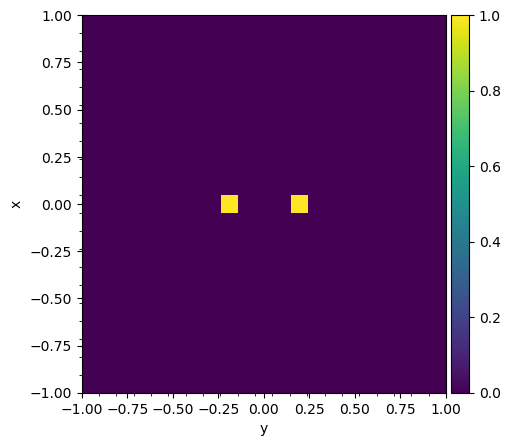

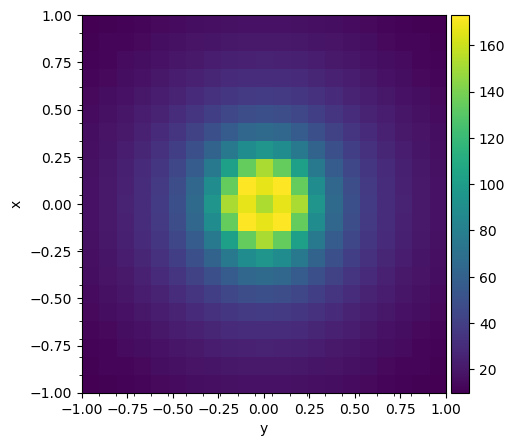

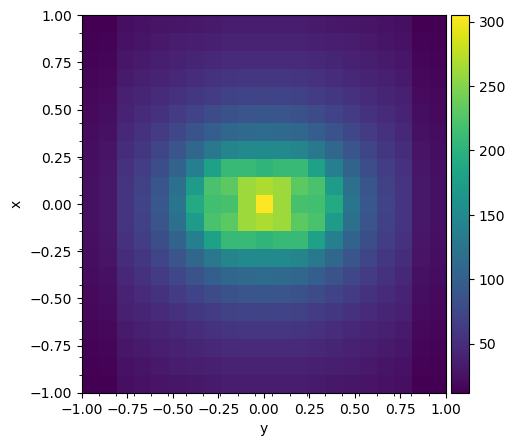

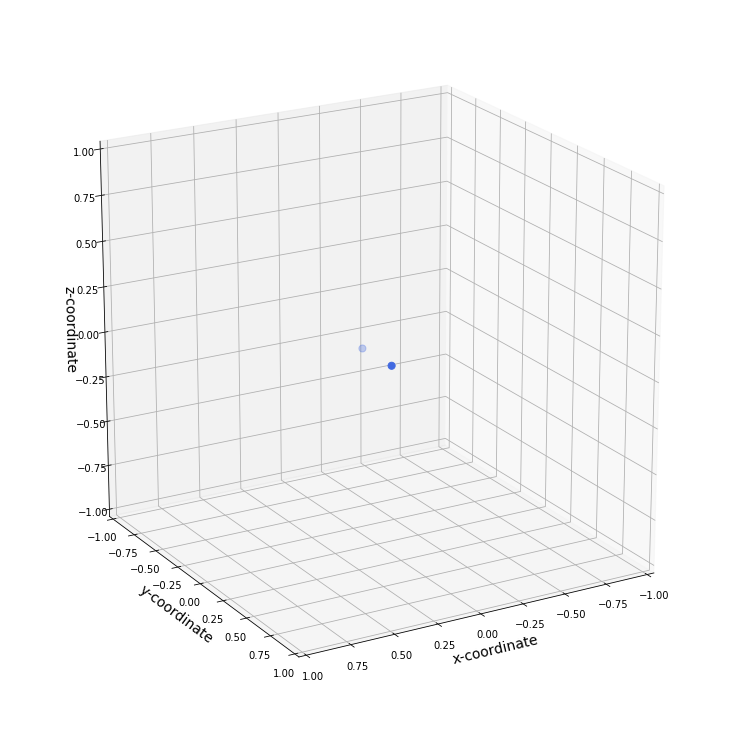

In [374]:
# set inital parameters
N = 4
size = 21
dt = 0.01
nb_step = 10

# set the ptcls
x_select = 2
if x_select == 0: 
    x=np.random.rand(N,3)*2-1 #Random N ptcl
    v_0=x*0
if x_select == 1: 
    x=np.array([[0.0,0.0,0.0]]) # Ptcl in the center
    v_0=x*0
if x_select == 2: 
    x=np.array([[0.0,-0.15,0.0],[0.0,0.15,0.0]]) # Pair of particles
    v_0=np.array([[3.0,0.0,0.0],[-3.0,0.0,0.0]]) # speed of each particle.
    
# Initilise the system
x, rho, edge, greens_f, phi = Initialize(x, size,a=0.006,plot_2D=True, plot_3D=True,sc_factor = 10000)

Step : 0
[-1.77635684e-14  3.92000000e+00 -1.77635684e-14] [3. 0. 0.] [ 3.0000000e+00  1.9600000e-02 -8.8817842e-17]
[-1.59872116e-14 -3.92000000e+00 -1.95399252e-14] [-3.  0.  0.] [-3.00000000e+00 -1.96000000e-02 -9.76996262e-17]
E= 11.109374999999996   K= 18.0   P= -6.890625000000005
Step : 1
[-1.77635684e-14  3.92000000e+00 -1.77635684e-14] [ 3.0000000e+00  1.9600000e-02 -8.8817842e-17] [ 3.00000000e+00  3.92000000e-02 -1.77635684e-16]
[-1.59872116e-14 -3.92000000e+00 -1.95399252e-14] [-3.00000000e+00 -1.96000000e-02 -9.76996262e-17] [-3.00000000e+00 -3.92000000e-02 -1.95399252e-16]
E= 11.110143319999995   K= 18.00076832   P= -6.890625000000005
Step : 2
[-1.03764706e+00  2.33952255e+00 -1.95399252e-14] [ 3.00000000e+00  3.92000000e-02 -1.77635684e-16] [ 2.99481176e+00  5.08976127e-02 -2.75335310e-16]
[ 1.03764706e+00 -2.33952255e+00 -1.77635684e-14] [-3.00000000e+00 -3.92000000e-02 -1.95399252e-16] [-2.99481176e+00 -5.08976127e-02 -2.84217094e-16]
E= 12.490573279999998   K= 18.00307

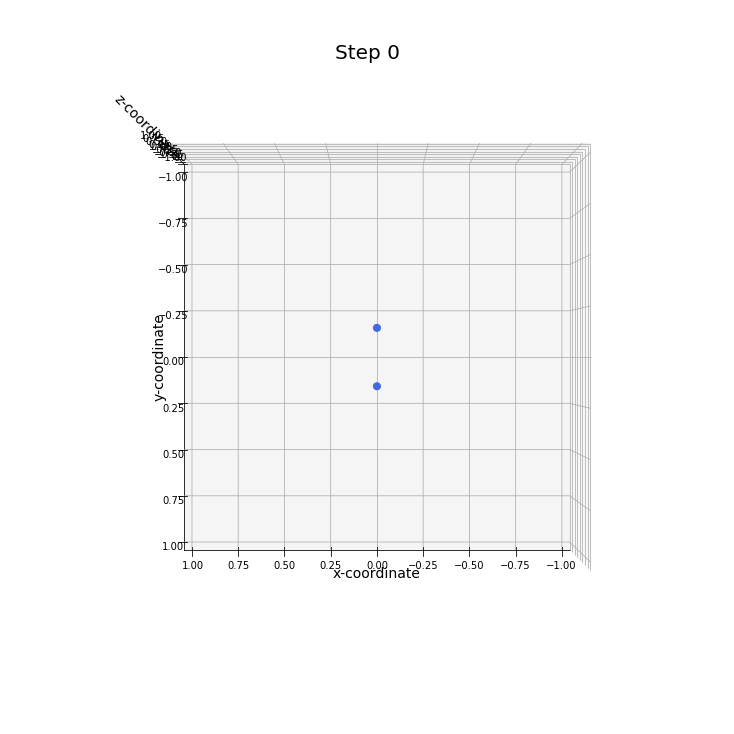

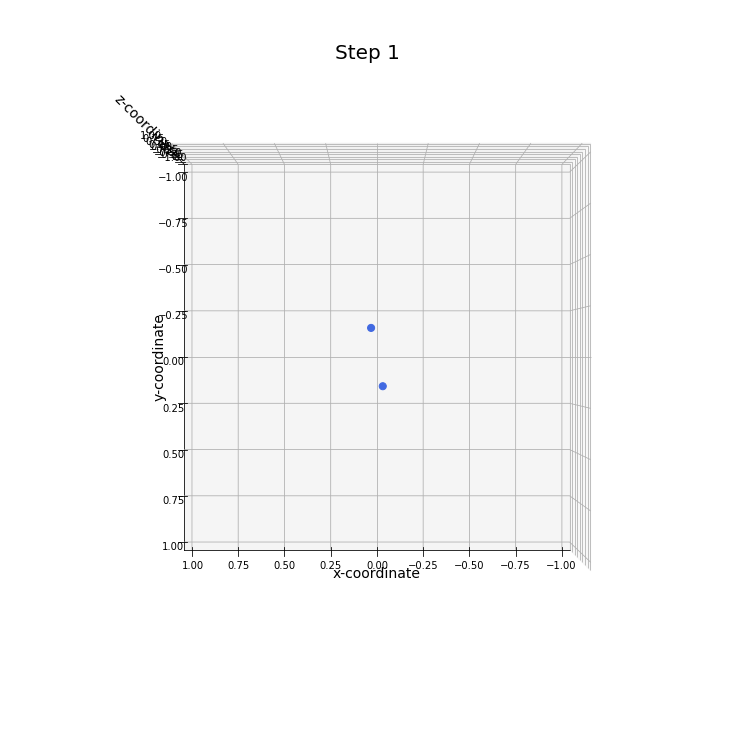

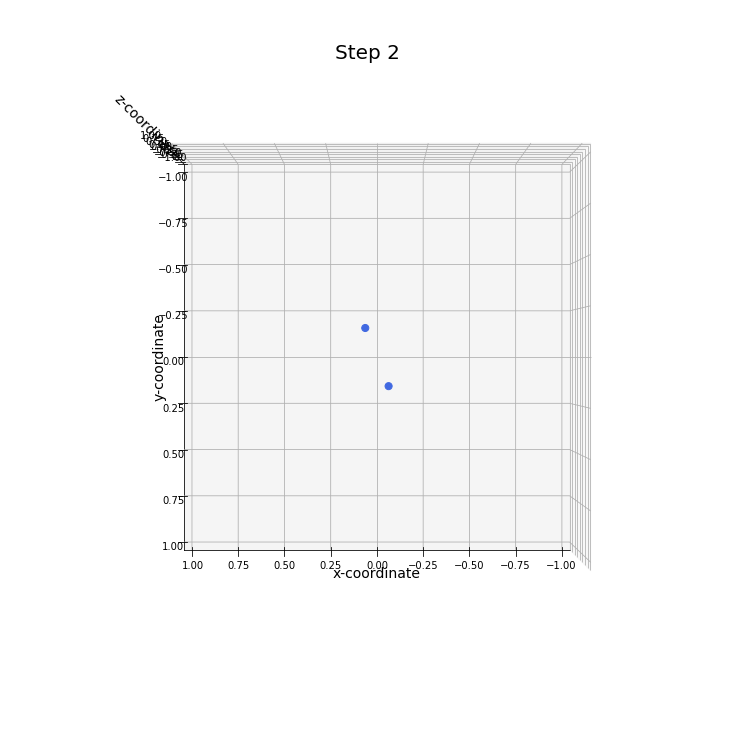

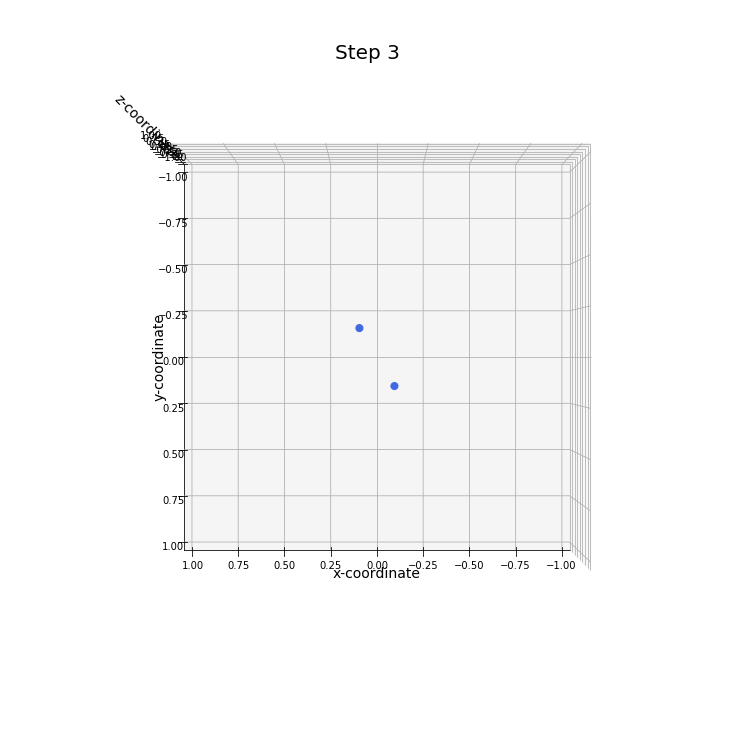

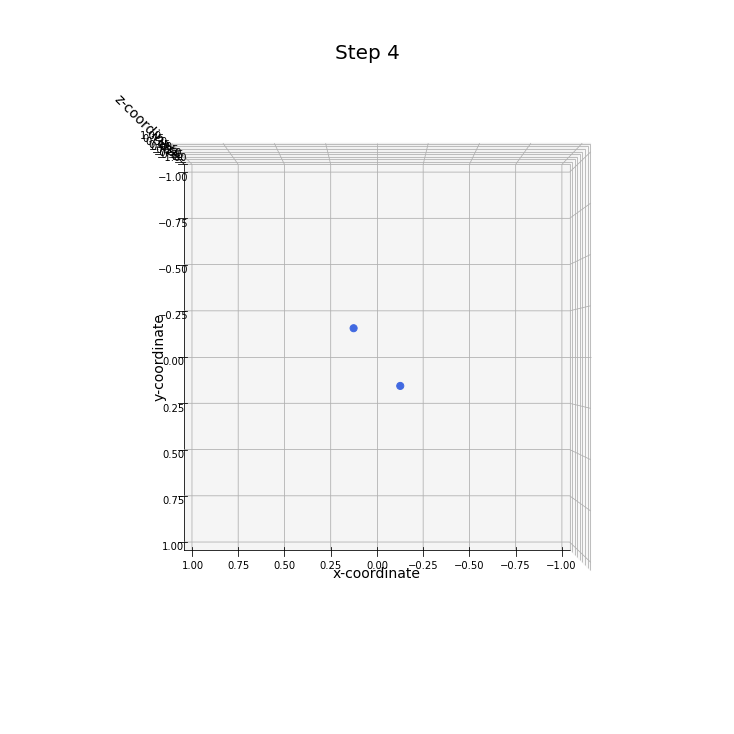

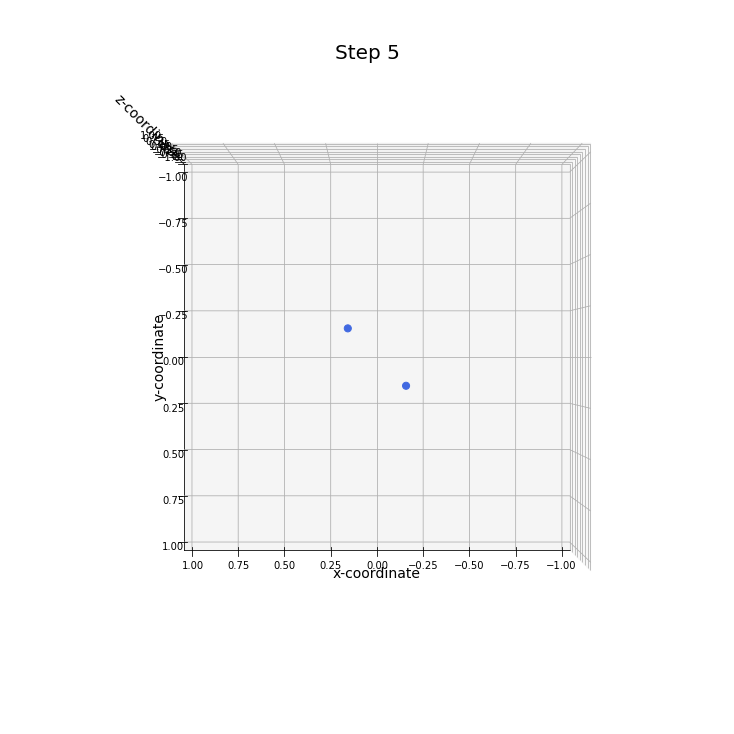

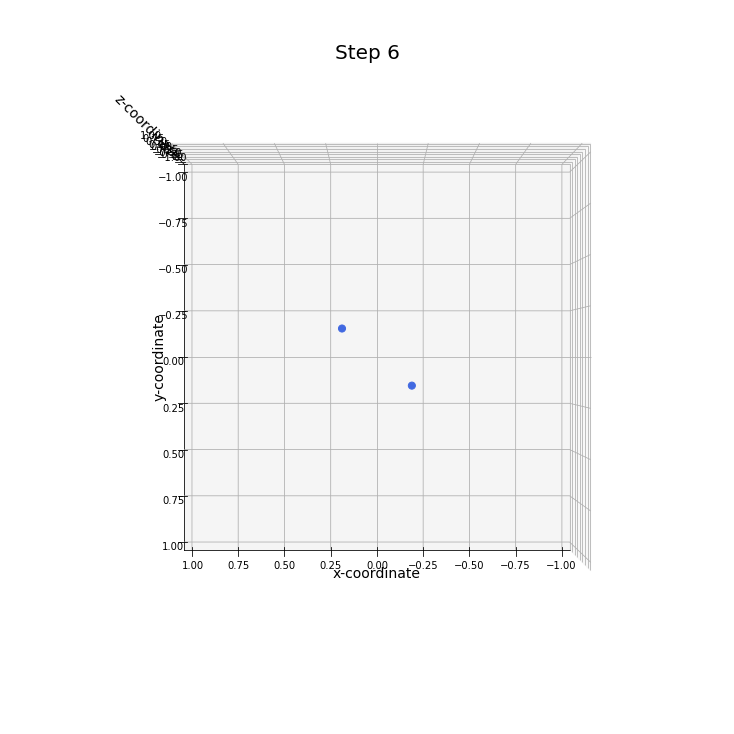

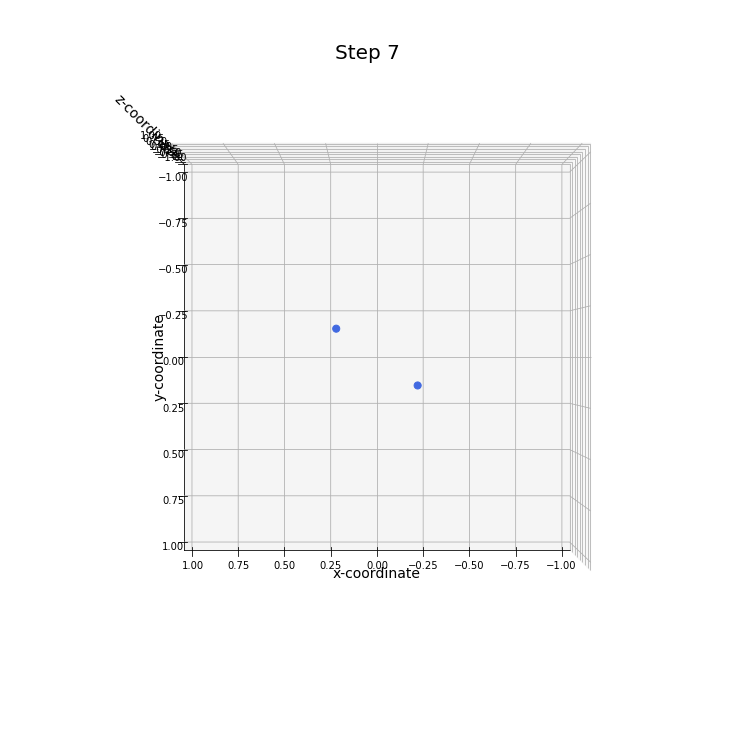

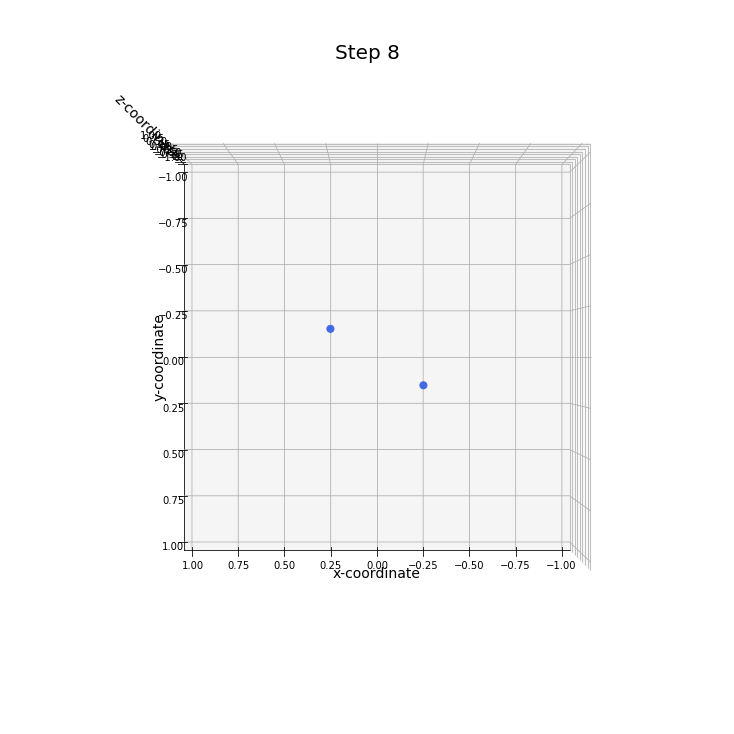

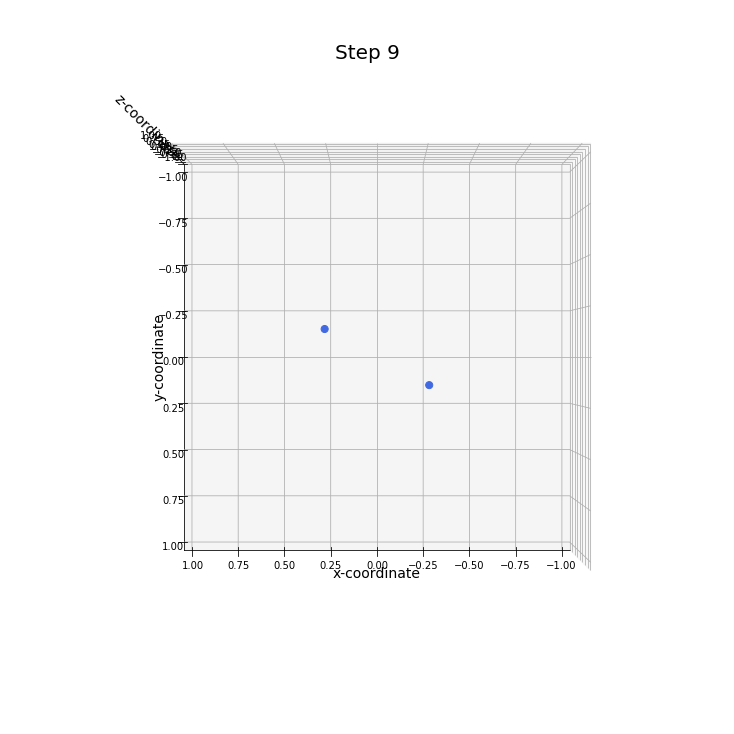

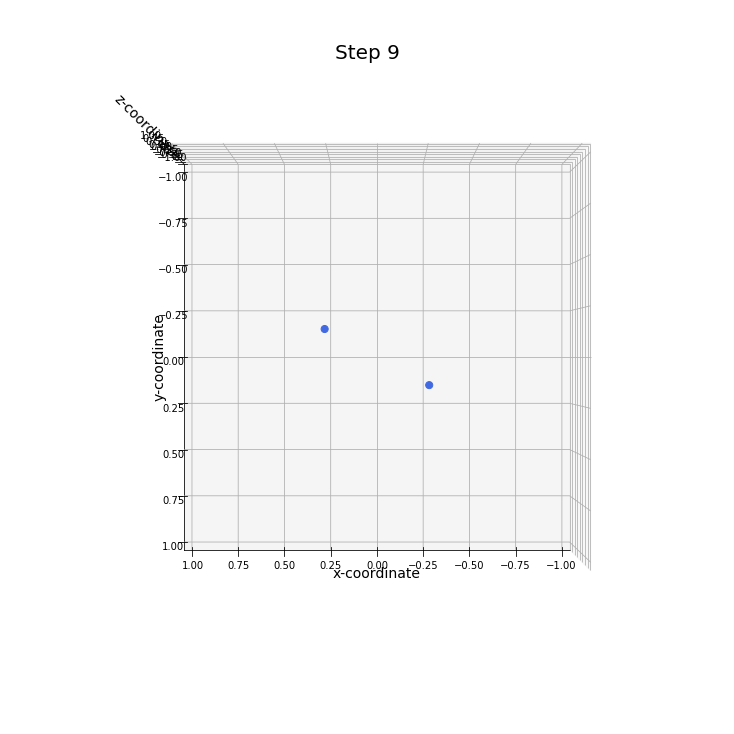

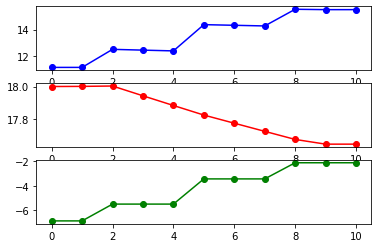

In [375]:
Evolve(dt, size, nb_step, x, rho, phi, rho, edge, greens_f, v_0, 
       show_freq=1,sc_factor=10000,plot_3D = True, save_3D=False, name_file = "fig", view1=90, view2=90)  

In [ ]:
            i = (i%size)# assures that the indices are inside the box
            j = (j%size)
            k = (k%size)
            assert i>=0 and i<size, "Error ijk ={}{}{}".format(i,j,k)

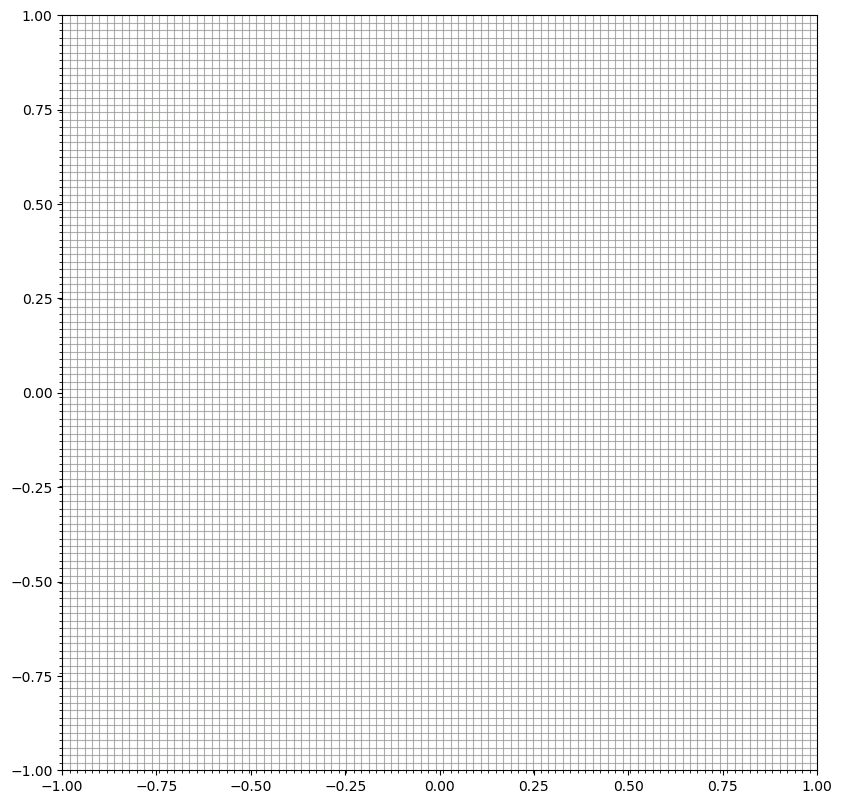

In [81]:
    i,j,k = x_to_ijk(x_n[0],rho,edge)
    ptcl1_acc = acc_n[k,j,i]
    i,j,k = x_to_ijk(x_n[1],rho,edge)
    ptcl2_acc = acc_n[k,j,i]
    acc_ptcls = np.concatenate(([ptcl1_acc], [ptcl2_acc]), axis=0)
    plot(edge[0], edge[1], np.transpose(x_n)[1], np.transpose(x_n)[0], np.transpose(acc_n)[1].sum(axis=2), 
    np.transpose(acc_ptcls)[1], np.transpose(acc_ptcls)[0], 
    plot_scatter=True, plot_quiver=True, grid=True, cmap="viridis")

In [ ]:
# Other function to plot stuff (Thanks Marcus!)
def plot(bin_edges_x, bin_edges_y, x, y, field, fx, fy, plot_scatter=True, plot_quiver=True, grid=True, cmap="viridis",scale_arrow=1):
    """
    A useful function for plotting parameters for the nbody assignment
    
    Most variables should be self explanatory.
    
    field should be for example the density field, potential field, forces... Whatever
    you think would be helpful to plot :)
    
    (fx, fy) are only for if you want to quiver plot and should be the force for each particle
    arranged in the same order as (x,y)
    """
    fig,ax = plt.subplots(figsize=(10,10), dpi=100)
    minor_ticks_x = bin_edges_x
    minor_ticks_y = bin_edges_y
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(minor_ticks_y, minor=True)
    ax.set(xlim=(minor_ticks_x[0], minor_ticks_x[-1]), ylim=(minor_ticks_x[0], minor_ticks_x[-1]))
    if grid:
        ax.grid(which='minor', alpha=0.75, color='xkcd:grey')
    if plot_scatter:
        scat = ax.scatter(x, y, color='k', s=10)
    cax = ax.imshow(
        field,
        # Extent goes (left, right, bottom, top)
        origin="lower",
        extent=(minor_ticks_x[0], minor_ticks_x[-1], minor_ticks_y[0], minor_ticks_y[-1]), 
        cmap=cmap
    )
    if plot_quiver:
        qax = ax.quiver(
            x, 
            y,
            fx, 
            fy,
            units="x",
            width=0.0005*len(bin_edges_x)*scale_arrow,
            color="w"
        )
    
    plt.show()